In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [266]:
import sys
from pathlib import Path
project_root = Path('./').resolve().parent
sys.path.append(str(project_root))

In [289]:
dflower=pd.read_csv('../output/alignn/quantile15.csv')
dfhigher=pd.read_csv('../output/alignn/quantile85.csv')
df50=pd.read_csv('../output/alignn//quantile50.csv')

In [290]:
len(df50)

4036

In [291]:
from sklearn.model_selection import train_test_split

index=df50.index.values
cal_ind, test_ind = train_test_split(index, test_size=0.5, random_state=42)

In [292]:
cal_y_lower=dfhigher['prediction'].values[cal_ind]
test_y_lower=dfhigher['prediction'].values[test_ind]
cal_y_med=df50['prediction'].values[cal_ind]
test_y_med=df50['prediction'].values[test_ind]
cal_y_upper=dflower['prediction'].values[cal_ind]
test_y_upper=dflower['prediction'].values[test_ind]

In [293]:
ycal=df50['truth'].values[cal_ind]
ytest=df50['truth'].values[test_ind]

In [294]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(ytest, test_y_med)
mae = mean_absolute_error(ytest, test_y_med)
mape = mean_absolute_percentage_error(ytest, test_y_med)
r2 = r2_score(ytest, test_y_med)
spearman_corr, _ = spearmanr(ytest, test_y_med)
kendall_corr, _ = kendalltau(ytest, test_y_med)
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.06887101358077305
Test set MAPE: 0.18878289666791334
Test set MSE: 0.009744773834729664
Test set R2 score: 0.6971940636506808
Test set spearman_corr: 0.8664533641683211
Test set kendall_corr: 0.6770110158793957


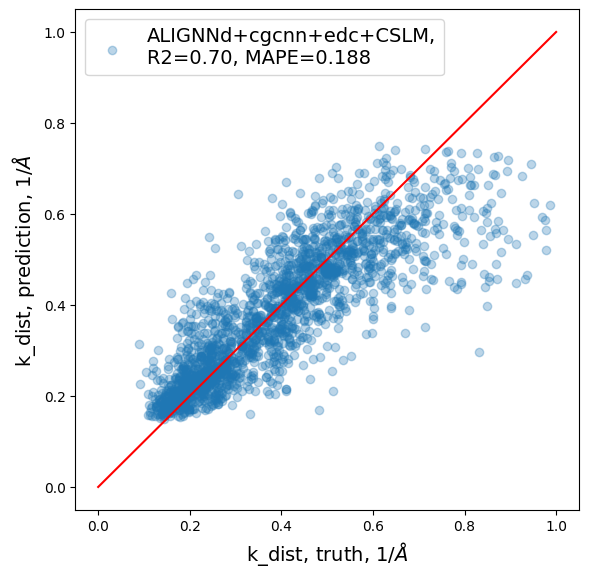

In [310]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6.5,6.5))
plt.scatter(ytest, test_y_med,alpha=0.3, label='ALIGNNd+cgcnn+edc+CSLM,\nR2=0.70, MAPE=0.188')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('k_dist, truth, $1/\AA$',fontsize=14)
plt.ylabel('k_dist, prediction, $1/\AA$',fontsize=14)
plt.legend(fontsize=14)
plt.savefig('../figures/ALIGNNd.png', dpi=600)
plt.show()

In [296]:
def conf_score(ytest, y_lower, y_upper):
    a=np.array(y_lower-ytest).reshape(-1, 1)
    b=np.array(ytest-y_upper).reshape(-1,1)
    return np.max(np.concatenate([a,b],axis=1),axis=1)

def conf_intervals(ytest, test_y_lower, test_y_upper, ycal, cal_y_lower, cal_y_upper, alpha=0.1):
    scores=conf_score(ycal, cal_y_lower, cal_y_upper)
    sorted_scores=np.sort(scores)
    conformal_correction=sorted_scores[int(len(ytest)*((1-alpha)*(1+1/len(ytest))))]
    y_lower=test_y_lower-conformal_correction*np.ones(len(ytest))
    y_upper=test_y_upper-conformal_correction*np.ones(len(ytest))
    return y_lower,y_upper

def regression_coverage_score(ytest, y_upper_k,y_lower_k):
    covered=0
    for i in range(len(ytest)):
        if((ytest[i]<y_upper_k[i]) and (ytest[i]>y_lower_k[i])):
            covered+=1
    return covered/len(ytest)

In [297]:
y_lower,y_upper=conf_intervals(ytest, test_y_lower, test_y_upper, ycal, cal_y_lower, cal_y_upper, alpha=0.3)

In [298]:
print(f'Coverage score : {regression_coverage_score(ytest, y_upper, y_lower)}')
print(f'Mean interval length : {np.mean(np.abs(y_lower-y_upper))}')

Coverage score : 0.703171456888008
Mean interval length : 0.17248620652180377


In [299]:
cov_score=regression_coverage_score(ytest, y_upper, y_lower)
mean_width=np.mean(np.abs(y_lower-y_upper))

In [300]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import randint, uniform
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
import warnings

random_state = 42

In [301]:
random_state = 18
rng = np.random.default_rng(random_state)
round_to = 3
perc_obs_plot = 0.05
num_plots = rng.choice(
    len(ytest), int(perc_obs_plot*len(ytest)), replace=False
    )

In [302]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound

In [303]:
def plot_prediction_intervals(
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx,
    round_to=3
):
    """
    Plot of the prediction intervals for each different conformal method.
    """

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_ - lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_ + error
    warning2 = y_test_sorted_ < y_pred_sorted_ - error
    warnings = warning1 + warning2

    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        alpha=0.8,
        label="Inside prediction interval"
    )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="midnightblue",
        alpha=0.8,
        label="Outside prediction interval"
    )

    # Labels
    axs.set_xlabel("$k_{dist}$, truth, $1/\\AA$", fontsize=14)
    axs.set_ylabel("$k_{dist}$, prediction, $1/\\AA$", fontsize=14)

    # Make axis tick labels larger
    axs.tick_params(axis='both', labelsize=14)

    # Annotation box in upper-left corner
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, round_to)}\n"
            f"Interval width: {np.round(width, round_to)}",
            textprops=dict(size=14)
        ),
        xy=(0.02, 0.98),          # upper-left corner in axes coordinates
        xycoords="axes fraction",
        box_alignment=(0, 1),
        frameon=True
    )
    axs.add_artist(ab)

    # Identity line
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),
        np.max([axs.get_xlim(), axs.get_ylim()])
    ]
    axs.plot(lims, lims, alpha=0.75, color="red", label="x=y")
    axs.set_xlim(lims)
    axs.set_ylim(lims)

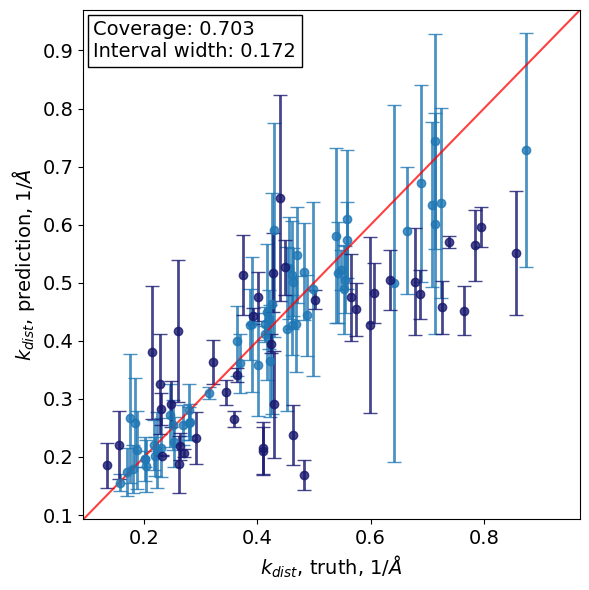

In [304]:
from matplotlib.offsetbox import AnnotationBbox, TextArea
perc_obs_plot = 0.05
num_plots = rng.choice(
    len(ytest), int(perc_obs_plot*len(ytest)), replace=False
    )

fig, ax = plt.subplots(figsize=(6, 6))

plot_prediction_intervals(
    ax,
    ytest,
    test_y_med,
    y_lower,
    y_upper,
    cov_score,
    mean_width,
    num_plots
)

# ax.legend()
plt.tight_layout()
plt.savefig('../figures/ALIGNN_CQR_70.png', dpi=600)
plt.show()

In [256]:
# from sklearn.linear_model import QuantileRegressor

# # quantile < 0.5 penalizes underestimation more
# q = 0.  # You can tune this
# model = QuantileRegressor(quantile=q, alpha=0, fit_intercept=True)
# X_dummy = np.ones((len(y_train), 1)) # dummy feature, constant model
# model.fit(X_dummy, y_train)
# ypred=model.predict(X_dummy)

# c_opt = ypred[0]
# c_opt

In [257]:
# CQR90: c_opt=0.158, CQR80: c_opt=0.184, CQR70: c_opt=0.205

In [305]:
c_opt=0.205

In [306]:
dummy_errors=c_opt-ytest

In [307]:
errors=y_lower-ytest
errors_pos=errors*np.array([errors>0],dtype='int').ravel()
errors_pos=[x for x in errors_pos if x != 0]

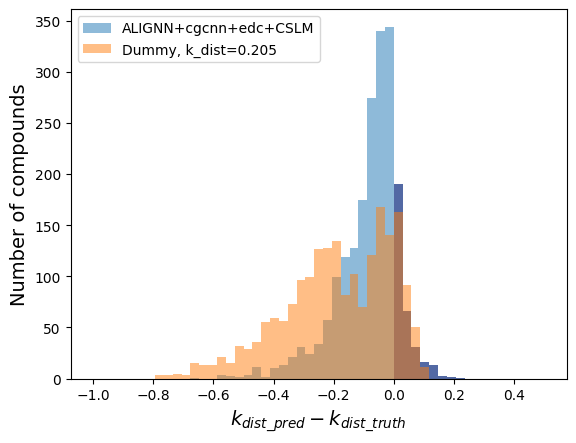

In [308]:
plt.hist(errors, bins=51, range=(-1,0.5), alpha=0.5,label='ALIGNN+cgcnn+edc+CSLM')
plt.hist(errors_pos, bins=51, range=(-1,0.5), alpha=0.5,color='midnightblue')
plt.hist(dummy_errors, bins=51, range=(-1,0.5), alpha=0.5, label=f'Dummy, k_dist={np.round(c_opt,3)}')
plt.xlabel('$k_{dist\_pred}-k_{dist\_truth}$', fontsize=14)
plt.ylabel('Number of compounds',fontsize=14)
plt.legend()
plt.savefig('../figures/ALIGNNd+baseline_CQR70.png', dpi=600)
plt.show()

In [262]:
np.mean(np.abs(errors)),np.mean(np.abs(dummy_errors))

(np.float64(0.09479961518186324), np.float64(0.2003685476739346))

In [263]:
np.sum([errors>0]), np.sum([errors>0])/len(errors), np.sum([dummy_errors>0]), np.sum([dummy_errors>0])/len(dummy_errors)

(np.int64(322),
 np.float64(0.1595639246778989),
 np.int64(316),
 np.float64(0.1565906838453915))

In [264]:
1-np.sum([errors>0])/len(errors), 1-np.sum([dummy_errors>0])/len(dummy_errors)

(np.float64(0.8404360753221011), np.float64(0.8434093161546086))

In [469]:
df=pd.read_pickle('/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/data/cgcnn_junwen_oct_6_kdist/junwen_6_oct_no_structural_duplicates_kdist_with_supercell.pkl')

In [470]:
da=pd.read_pickle('/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/data/cgcnn_junwen_oct_6_kdist/wall_times.pkl')

In [471]:
for i in range(len(da['Source ID'].values)):
    da['Source ID'].values[i]=str(da['Source ID'].values[i])

In [406]:
test_ind_original=df50['id'].values[test_ind]

In [407]:
testset=pd.DataFrame()

In [408]:
testset['source_db_id']=df.iloc[test_ind_original]['source_db_id'].values
testset['ytest']=ytest
testset['ypred']=test_y_med
testset['ylower']=y_lower
testset['ydummy']=c_opt*np.ones(len(testset))

In [409]:
dummy_times=[]
lower_times=[]
true_times=[]
predicted_times=[]
ypred_corr=[]

In [410]:
for i in range(len(testset)):
    ind=testset.iloc[i]['source_db_id']
    dx=da.loc[da['Source ID']==ind]
    true_k_dist=testset.iloc[i]['ytest']
    true_time=dx.loc[np.abs(dx['k_dist']-true_k_dist)<0.002]['wall_time_s'].values[0]
    true_times.append(true_time)
    try:
        predicted_k_dist=testset.iloc[i]['ypred']
        ind_pred=np.searchsorted(np.array(predicted_k_dist*np.ones(len(dx))-dx['k_dist']),0)
        ypred_corr.append(dx.iloc[ind_pred]['k_dist'])
        predicted_time=dx.iloc[ind_pred]['wall_time_s']
    except:
        predicted_time=np.nan
        ypred_corr.append(np.nan)
    predicted_times.append(predicted_time)
    try:
        lower_k_dist=testset.iloc[i]['ylower']
        ind_lower=np.searchsorted(np.array(lower_k_dist*np.ones(len(dx))-dx['k_dist']),0)
        lower_time=dx.iloc[ind_lower]['wall_time_s']
    except:
        lower_time=np.nan
    lower_times.append(lower_time)
    try:
        dummy_k_dist=testset.iloc[i]['ydummy']
        ind_dummy=np.searchsorted(np.array(dummy_k_dist*np.ones(len(dx))-dx['k_dist']),0)
        dummy_time=dx.iloc[ind_dummy]['wall_time_s']
    except:
        dummy_time=np.nan
    dummy_times.append(dummy_time)

In [411]:
testset['ypred_corr']=ypred_corr
testset['true_times']=true_times
testset['predicted_times']=predicted_times
testset['lower_times']=lower_times
testset['dummy_times']=dummy_times

In [412]:
testset1=testset.loc[~testset['ypred_corr'].isna()]

In [413]:
dy=testset.loc[~testset['lower_times'].isna()]
dyy=dy.loc[~dy['dummy_times'].isna()]

In [423]:
len(dyy), len(testset)

(927, 2018)

In [414]:
def wasted_time(true_val,pred_val):
    times=[]
    for i in range(len(true_val)):
        x=pred_val[i]-true_val[i]
        if(x>=0):
            times.append(x)
        else:
            times.append(pred_val[i])
    return times

In [415]:
cost_dummy=wasted_time(dyy['true_times'].values,dyy['dummy_times'].values)
cost_lower=wasted_time(dyy['true_times'].values,dyy['lower_times'].values)
cost_pred=wasted_time(dyy['true_times'].values,dyy['predicted_times'].values)

In [416]:
np.mean(cost_dummy),np.mean(cost_lower)

(np.float64(216.72893203883496), np.float64(216.38728155339803))

In [417]:
np.mean(dyy['true_times'])

np.float64(360.121003236246)

In [418]:
np.mean(cost_dummy)-np.mean(cost_lower), (np.mean(cost_dummy)-np.mean(cost_lower))/np.mean(cost_dummy)

(np.float64(0.34165048543692933), np.float64(0.0015763953719649673))